In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [9]:

# data loading and presenting
orbits = ['ORB26']


orbits_preproc_data = []


for i, orbit in enumerate(orbits):
    str = f"{orbits[i]}_EUR_EPHIO.csv"
    current_orbit_data = []
    df = pd.read_csv(str)

    # Inputs: X, Y, Z coordinates
    X_raw = df[['X', 'Y', 'Z']].values
    # Outputs: Magnetic Field Bx, By, Bz
    y_raw = df[['BX', 'BY', 'BZ']].values

    # Scale data to [-1, 1] for Tanh stability and easier gradient flow
    input_scaler = MinMaxScaler(feature_range=(-1, 1))
    output_scaler = MinMaxScaler(feature_range=(-1, 1))

    X_scaled = input_scaler.fit_transform(X_raw)
    y_scaled = output_scaler.fit_transform(y_raw)

    # to tensor
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    # data split
    X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


    current_orbit_data.append((X_raw, y_raw, X_train, y_train, X_val, y_val, input_scaler, output_scaler))
    orbits_preproc_data.append(current_orbit_data)

# print(orbits_preproc_data)  # Example: Print shape of raw inputs for first orbit

In [10]:

# define the model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Standard MLP architecture
        self.net = nn.Sequential(
            nn.Linear(3, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 3)  # Output: Bx, By, Bz
        )

    def forward(self, x):
        return self.net(x)


In [11]:
def physics_loss_function(model, x_collocation):
    """
    Calculates the residuals of Maxwell's equations at random points.
    """
    # Enable gradient tracking for the input coordinates (required for derivative)
    x_collocation.requires_grad = True

    # Predict B-field at these random points
    b_pred = model(x_collocation)

    # Separate components
    bx = b_pred[:, 0].unsqueeze(1)
    by = b_pred[:, 1].unsqueeze(1)
    bz = b_pred[:, 2].unsqueeze(1)

    # --- Compute Gradients (Automatic Differentiation) ---
    # We need d(Bi)/d(xj)

    # Gradients for Bx
    grads_bx = torch.autograd.grad(bx, x_collocation, grad_outputs=torch.ones_like(bx), create_graph=True)[0]
    dbx_dx, dbx_dy, dbx_dz = grads_bx[:, 0], grads_bx[:, 1], grads_bx[:, 2]

    # Gradients for By
    grads_by = torch.autograd.grad(by, x_collocation, grad_outputs=torch.ones_like(by), create_graph=True)[0]
    dby_dx, dby_dy, dby_dz = grads_by[:, 0], grads_by[:, 1], grads_by[:, 2]

    # Gradients for Bz
    grads_bz = torch.autograd.grad(bz, x_collocation, grad_outputs=torch.ones_like(bz), create_graph=True)[0]
    dbz_dx, dbz_dy, dbz_dz = grads_bz[:, 0], grads_bz[:, 1], grads_bz[:, 2]

    # --- Constraint 1: Divergence Free (No Monopoles) ---
    # div(B) = dBx/dx + dBy/dy + dBz/dz = 0
    divergence = dbx_dx + dby_dy + dbz_dz
    loss_div = torch.mean(divergence ** 2)

    # --- Constraint 2: Curl Free (Current Free Region) ---
    # curl(B) = 0 (assuming we are in the space above the ocean)
    curl_x = dbz_dy - dby_dz
    curl_y = dbx_dz - dbz_dx
    curl_z = dby_dx - dbx_dy
    loss_curl = torch.mean(curl_x**2 + curl_y**2 + curl_z**2)

    return loss_div + loss_curl

# Helper to generate random collocation points
def get_collocation_points(n_points=2000, bounds=(-1, 1)):
    # Generate random (x,y,z) points within the scaled domain
    return (bounds[1] - bounds[0]) * torch.rand(n_points, 3) + bounds[0]


In [12]:

# training
epochs = 5000
lambda_physics = 0.01  # Weighting factor for physics loss

print("Starting PINN training...")
# current_orbit_data.append((X_raw, y_raw, X_train, y_train, X_val, y_val, input_scaler, output_scaler))
orbits_models_data = []
for i, orbit_data in enumerate(orbits_preproc_data):
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion_data = nn.MSELoss()


    print(f"Training on Orbit: {orbits[i]}")

    X_train, y_train = orbit_data[0][2], orbit_data[0][3]

    loss_history = {'data': [], 'physics': []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # --- A. Data Loss (Supervised) ---
        # Fit the actual spacecraft measurements
        pred_data = model(X_train)
        loss_data = criterion_data(pred_data, y_train)

        # --- B. Physics Loss (Unsupervised) ---
        # Enforce Maxwell's equations at random points in the domain
        x_phys = get_collocation_points(n_points=1000)
        loss_phys = physics_loss_function(model, x_phys)

        # --- C. Total Loss ---
        loss_total = loss_data + (lambda_physics * loss_phys)

        loss_total.backward()
        optimizer.step()

        loss_history['data'].append(loss_data.item())
        loss_history['physics'].append(loss_phys.item())

        if (epoch + 1) % 500 == 0:
            print(f"Orbit: {orbits[i]} | Epoch {epoch+1}/{epochs}: Data Loss={loss_data.item():.5f} | Physics Loss={loss_phys.item():.5f}")

    orbits_models_data.append((model.state_dict(), loss_history))

Starting PINN training...
Training on Orbit: ORB26
Orbit: ORB26 | Epoch 500/5000: Data Loss=0.02658 | Physics Loss=0.11338
Orbit: ORB26 | Epoch 1000/5000: Data Loss=0.01051 | Physics Loss=0.52767
Orbit: ORB26 | Epoch 1500/5000: Data Loss=0.00320 | Physics Loss=0.31347
Orbit: ORB26 | Epoch 2000/5000: Data Loss=0.00242 | Physics Loss=0.13660
Orbit: ORB26 | Epoch 2500/5000: Data Loss=0.00248 | Physics Loss=0.17782
Orbit: ORB26 | Epoch 3000/5000: Data Loss=0.00282 | Physics Loss=0.21056
Orbit: ORB26 | Epoch 3500/5000: Data Loss=0.00240 | Physics Loss=0.08133
Orbit: ORB26 | Epoch 4000/5000: Data Loss=0.00281 | Physics Loss=0.11093
Orbit: ORB26 | Epoch 4500/5000: Data Loss=0.00236 | Physics Loss=0.02380
Orbit: ORB26 | Epoch 5000/5000: Data Loss=0.00262 | Physics Loss=0.02833


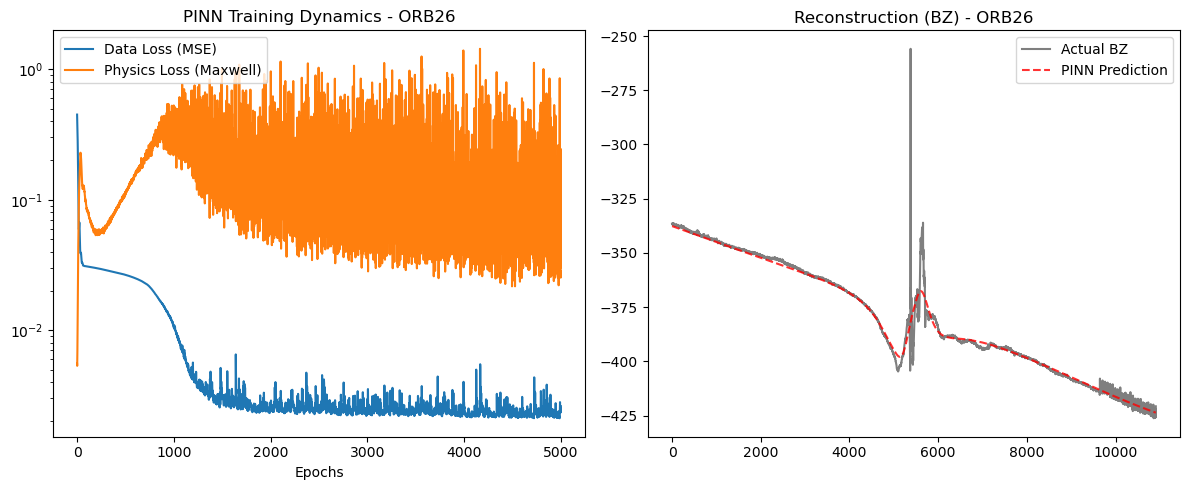

PINN Model for ORB26 saved.


In [13]:
# ... (Previous code remains the same up to the loop) ...

# results

for i, (orbit_packet, model_packet) in enumerate(zip(orbits_preproc_data, orbits_models_data)):

    # FIX 2: Unpack correctly.
    # orbit_packet is a list containing 1 tuple: [(X_raw, y_raw...)]
    # We need to grab that first element [0]
    data_tuple = orbit_packet[0]
    X_raw, y_raw, X_train, y_train, X_val, y_val, input_scaler, output_scaler = data_tuple

    # model_packet is a tuple: (model_state, loss_history)
    model_state, loss_history = model_packet

    # Load the specific model state for this orbit
    model.load_state_dict(model_state)

    # --- Visualization ---
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['data'], label='Data Loss (MSE)')
    plt.plot(loss_history['physics'], label='Physics Loss (Maxwell)')
    plt.yscale('log')
    plt.title(f'PINN Training Dynamics - {orbits[i]}')
    plt.xlabel('Epochs')
    plt.legend()

    # Prediction Plot
    model.eval()
    with torch.no_grad():
        X_scaled_current = input_scaler.transform(X_raw)
        X_tensor_current = torch.tensor(X_scaled_current, dtype=torch.float32)

        full_pred_scaled = model(X_tensor_current)
        full_pred = output_scaler.inverse_transform(full_pred_scaled.numpy())

    plt.subplot(1, 2, 2)
    plt.plot(y_raw[:, 2], 'k-', alpha=0.5, label='Actual BZ')
    plt.plot(full_pred[:, 2], 'r--', alpha=0.8, label='PINN Prediction')
    plt.title(f'Reconstruction (BZ) - {orbits[i]}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'pinn_results_{orbits[i]}.png') # Save with unique name
    plt.show()

    # Save model
    torch.save(model.state_dict(), f'europa_pinn_model_{orbits[i]}.pth')
    print(f"PINN Model for {orbits[i]} saved.")

In [14]:

# # ==========================================
# # 5. Results & Saving
# # ==========================================
# orbits_full_data = zip(*orbits_preproc_data, *orbits_models_data)

# for (X_raw, y_raw, X_train, y_train, X_val, y_val, input_scaler, output_scaler), (model_state, loss_history) in orbits_full_data:
#     model.load_state_dict(model_state)

#     plt.figure(figsize=(12, 5))
#     # Loss Plot
#     plt.subplot(1, 2, 1)
#     plt.plot(loss_history['data'], label='Data Loss (MSE)')
#     plt.plot(loss_history['physics'], label='Physics Loss (Maxwell)')
#     plt.yscale('log')
#     plt.title('PINN Training Dynamics')
#     plt.xlabel('Epochs')
#     plt.legend()

#     # Prediction Plot
#     model.eval()
#     with torch.no_grad():
#         full_pred_scaled = model(X_tensor)
#         full_pred = output_scaler.inverse_transform(full_pred_scaled.numpy())

#     plt.subplot(1, 2, 2)
#     plt.plot(y_raw[:, 2], 'k-', alpha=0.5, label='Actual BZ')
#     plt.plot(full_pred[:, 2], 'r--', alpha=0.8, label='PINN Prediction')
#     plt.title('Reconstruction (BZ Component)')
#     plt.legend()

#     plt.tight_layout()
#     plt.savefig('pinn_europa_training_results.png')
#     plt.show()


#     torch.save(model.state_dict(), 'europa_pinn_model{}.pth')
#     print("PINN Model saved.")